<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/heatmaps/pneumonia_playaround_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [2]:
! pip install -q kaggle
from google.colab import files

In [3]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielwadell","key":"1321c28c9e239b238b153543de670b85"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:24<00:00, 35.5MB/s]
100% 2.29G/2.29G [00:25<00:00, 98.2MB/s]


In [6]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

In [8]:
!ls

chest-xray-pneumonia.zip  files  kaggle.json  sample_data


# X-ray Image Classification 

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using Convolutional Neural Networks. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle.


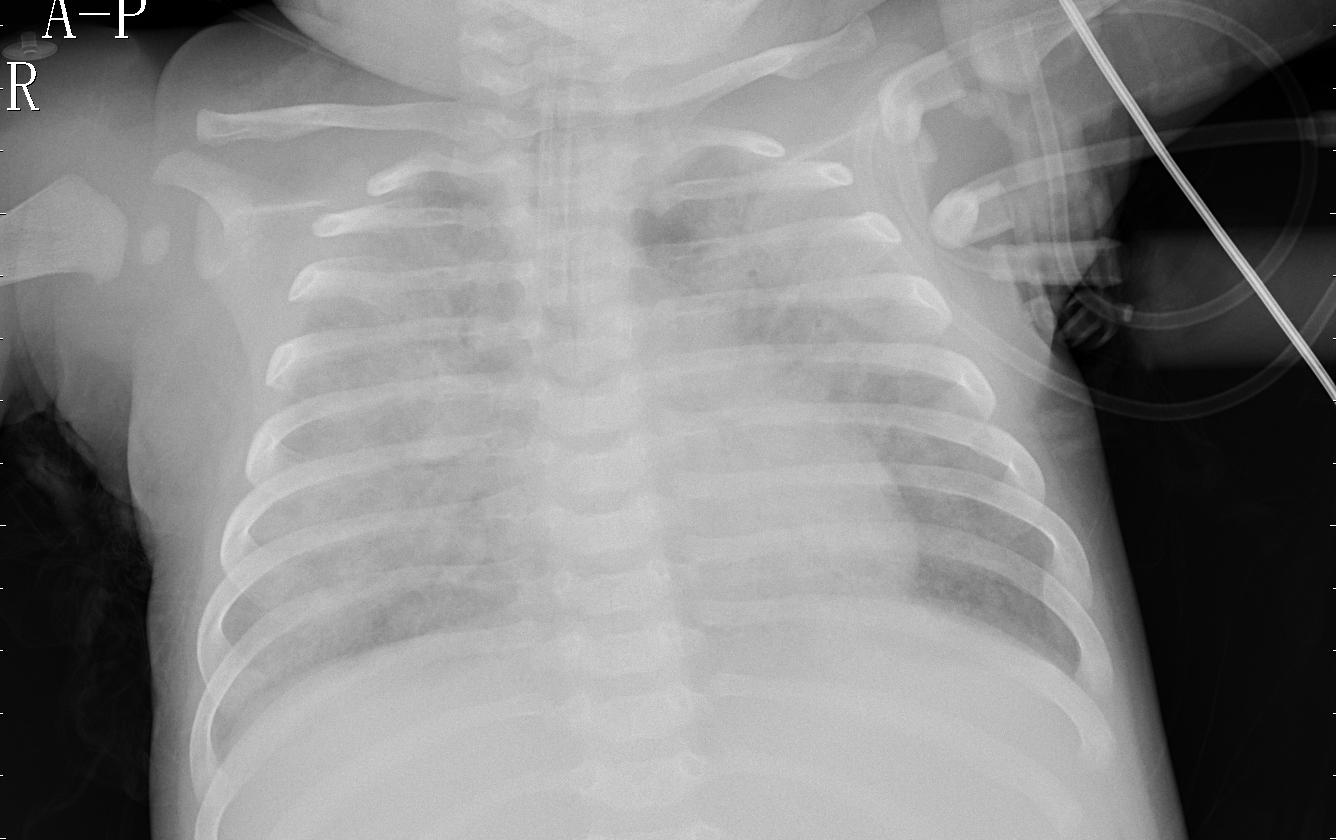

In [9]:
# The local path to the target image
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

display(Image(img_path))

Stuff about preprocessing

# Binary Classification

For our first model, we will first take the images from our drive, and preprocess them into data that can be fed into a CNN.

For this section, we will focus on predicting whether a patient has pneumonia or not.

In [10]:
def load_data(path):

  imgs = []
  labels = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels


In [11]:
# validation data was used as training data to debug things
X_train, y_train = load_data("/content/files/chest_xray/train")
X_test, y_test = load_data("/content/files/chest_xray/test")
# X_val, y_val = load_data("/content/files/chest_xray/val")

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)


In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## CNN

We will be testing our data on a simple CNN, with a dropout rate of 0.5.

In [ ]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# f1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

NameError: ignored

In [ ]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size)

Epoch 1/20
163/163 [==============================] - 26s 162ms/step - loss: 0.5762 - accuracy: 0.7439 - f1_m: 0.8453 - precision_m: 0.7543 - recall_m: 0.9786 - val_loss: 0.6056 - val_accuracy: 0.6464 - val_f1_m: 0.7755 - val_precision_m: 0.6400 - val_recall_m: 0.9953
Epoch 2/20
163/163 [==============================] - 26s 160ms/step - loss: 0.4524 - accuracy: 0.7924 - f1_m: 0.8660 - precision_m: 0.8266 - recall_m: 0.9212 - val_loss: 0.5279 - val_accuracy: 0.7401 - val_f1_m: 0.8205 - val_precision_m: 0.7067 - val_recall_m: 0.9846
Epoch 3/20
163/163 [==============================] - 26s 160ms/step - loss: 0.3896 - accuracy: 0.8351 - f1_m: 0.8911 - precision_m: 0.8631 - recall_m: 0.9296 - val_loss: 0.5766 - val_accuracy: 0.7401 - val_f1_m: 0.8186 - val_precision_m: 0.7087 - val_recall_m: 0.9798
Epoch 4/20
163/163 [==============================] - 26s 160ms/step - loss: 0.3502 - accuracy: 0.8489 - f1_m: 0.8995 - precision_m: 0.8791 - recall_m: 0.9286 - val_loss: 0.3472 - val_accuracy:

In [ ]:
'''
batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        class_mode='binary')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        class_mode='binary')

# todo: save the augmented data to a separate directory named: test_aug

history = model.fit(train_generator,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=validation_generator,validation_steps=X_test.shape[0]//batch_size)
'''

In [ ]:
model.evaluate_generator(gen_test, 50, workers=1)

In [ ]:
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Chance of Pneumonia:", (preds))

In [ ]:
# our code has a 91% validation accuracy on test data

In [ ]:
'''
#img_array = preprocess_input(get_img_array("/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg", size=(150,150)))

img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

# preds = model.predict(np.expand_dims(X_test[340], axis=0))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)


preds = model.predict(img)


print("Predicted:", (preds))
'''

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

In [ ]:
# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# model.fit(X_val, y_val, epochs=15, batch_size=32) #this line is for debug purposes

# things to consider
# cost function for false negatives and false positives
# slightly unbalanced data set -- oversample? undersample? both?
# three-way classification section

We graph our stuff here

##Imbalanced Data

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)

In [ ]:
class_weight = {0:1.94, 1:0.67}
print(class_weight)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight)

In [ ]:
model= tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=max,
    classes = 2,
    classifier_activation="softmax",
)

In [ ]:
opt=tf.keras.optimizers.Adam(
    learning_rate=0.015,
    name="Adam",

)

In [ ]:
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight)

In [ ]:
!pip install imblearn 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

#X_train_S, y_train_S = smote.fit_sample(X_train,y_train)


print(X_train[1])

In [ ]:
from collections import Counter
print(Counter(y_train_S))

# HEAT MAPS!

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [ ]:
# todo: fix potential problem for displaying the activation of the conv2d_3 layer.

img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"
img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)

last_conv_layer = model.get_layer('conv2d_3')
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

classifier_input = Input(shape=last_conv_layer.output.shape[1:])
cl_in = classifier_input

for i in [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]:
  cl_in = model.get_layer(i)(cl_in)

classifier_model = Model(classifier_input, cl_in)

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = K.mean(grads, axis=(0, 1, 2))

pooled_grads_value = pooled_grads.numpy() 

conv_layer_output_value = last_conv_layer_output.numpy()[0]

for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [ ]:
heatmap = np.maximum(heatmap, 0) / np.max(heatmap) # this might be a problem.

In [ ]:
plt.matshow(heatmap)
plt.show()

In [ ]:
# We load the original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "pneumonia_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

# Three-Way Classification

We will now be processing our data such that we will also be taking into consideration, the type of pneumonia one can be diagnosed with -- bacterial and viral.

In [ ]:
def load_data_2(path):
  imgs = []
  labels = []

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      # To reduce training costs, the images are resized to 200x200.
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)

      # one-hot encoded labels
      labels.append([int(not ('bacteria' in f or 'virus' in f)), int('bacteria' in f), int('virus' in f)])


      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1

      

  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels

In [ ]:
X_train, y_train = load_data_2("/content/files/chest_xray/train")
X_test, y_test = load_data_2("/content/files/chest_xray/test")
print(y_test)

We will now prepare our dataset for keras's datagen_from_directory.

In [ ]:
'''
# prepare three-way categorical data for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data for training
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..
'''

In [ ]:
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
'''

In [ ]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

In [ ]:
# history = model.fit(train_generator,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=validation_generator,validation_steps=X_test.shape[0]//batch_size)

In [ ]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size)

In [ ]:
model.evaluate_generator(gen_test, 50, workers=1)

In [ ]:
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Predicted:", (preds))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

# MORE HEAT MAPS

In [ ]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [ ]:
#SALIENCY

# sampling if needed

In [ ]:
bacterial_indices = np.array([i[0] == 1 and i[1] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 1 for i in y_train])
normal_indices = np.array([i[0] == 0 and i[1] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

Since there is a significant imbalance of bacterial data compared to normal and viral data, we will be oversampling the normal and viral data accordingly.

In [ ]:
# prepare the oversampling data

X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

In [ ]:
# in order for the data to be more or less equal, random sampling is used.
# viral and bacterial data will be oversampled to a size of 2500 in order to
# maintain an even ratio 

# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

print(normal_oversampling_indices)
print(viral_oversampling_indices)

In [ ]:
X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train = np.concatenate((X_train, X_train_concatenate_normal), axis=0)
X_train = np.concatenate((X_train, X_train_concatenate_viral))


# new Y_train
y_train = np.concatenate((y_train, y_train_concatenate_normal))
y_train = np.concatenate((y_train, y_train_concatenate_viral))

print(X_train.shape)

The proportions of the data have now been rebalanced to a relatively equal distribution.

In [ ]:
bacterial_indices = np.array([i[0] == 1 and i[1] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 1 for i in y_train])
normal_indices = np.array([i[0] == 0 and i[1] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

In [ ]:
# rudimentary CNN for the three-way classification
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
# todo: heatmaps! heatmaps! heatmaps! might turn the heatmaps into a whole function unto itself.

classifier_layer_names = [
    "dense_1"
]
img_array = preprocess_input(get_img_array(img_path, size = (299, 299)))

last_conv_layer = model.get_layer("block14_sepconv2_act")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
# for layer_name in classifier_layer_names:
#     x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    # print(preds[:, top_pred_index])
    top_class_channel = preds[:]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

print(pooled_grads.shape)

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

#visualizing what neural net sees

In [ ]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


ValueError: ignored

In [ ]:
for layer in model.layers:
    print(layer.name)

conv2d
activation
max_pooling2d
conv2d_1
activation_1
max_pooling2d_1


In [ ]:
layer = model.get_layer(name="max_pooling2d_1")
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=layer.output)

In [ ]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [ ]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, 299, 299, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [ ]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
tf.keras.preprocessing.image.save_img("0.png", img)

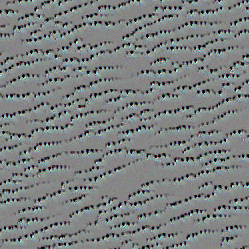

In [ ]:
display(Image("0.png"))

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31


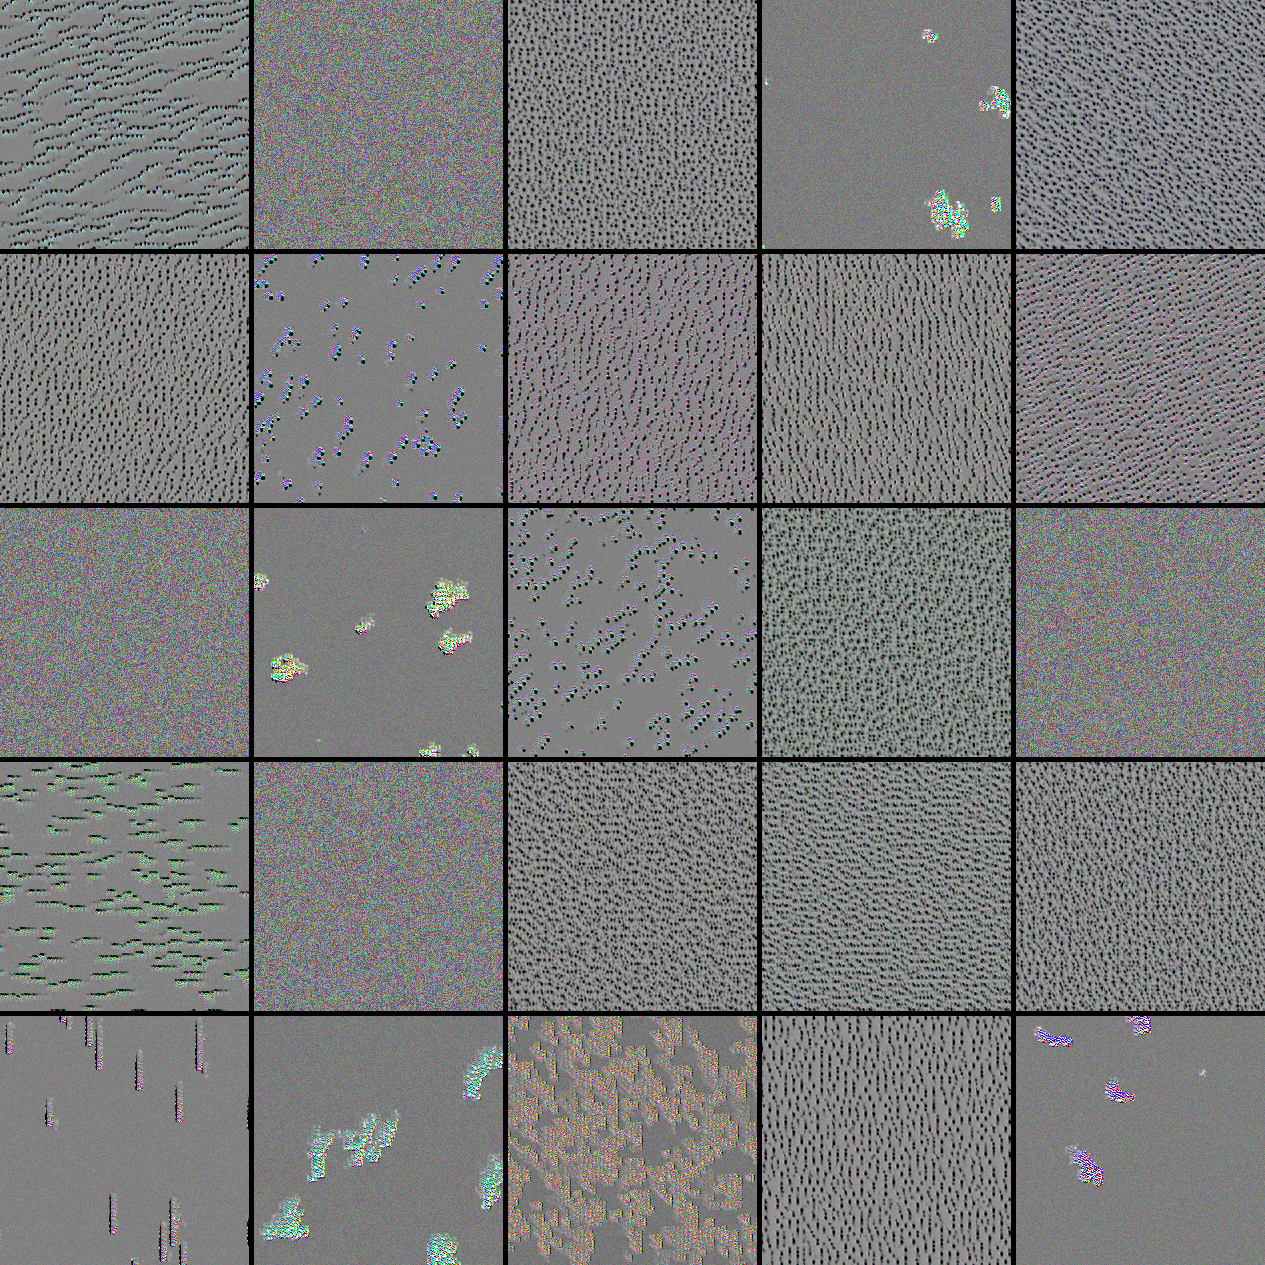

In [ ]:

all_imgs = []
for filter_index in range(32):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

margin = 5
n = 5
cropped_width = 299 - 25 * 2
cropped_height = 299 - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
tf.keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

#clustering

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_train_first_100 = np.array(np.float32(X_train).reshape(len(X_train), -1)/255)

X_train_first_100 = X_train_first_100[np.random.choice(X_train.shape[0], 100, replace=False)]

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train_first_100)

kmeans = KMeans(n_clusters=3, random_state=0)

label = kmeans.fit_predict(reduced_data)


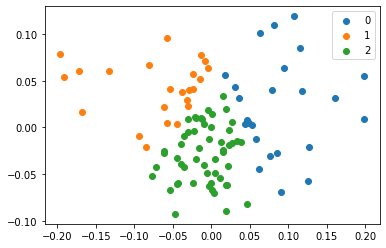

In [58]:
#Getting unique labels
 
u_labels = np.unique(label)

#plotting the results:
 
for i in u_labels:
    plt.scatter(reduced_data[label == i , 0] , reduced_data[label == i , 1] , label = i)
plt.legend()
plt.show()